In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from models.rootspike_glm import RootSpike_GLM
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"
Z_file = "spk_loc.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file).flatten()

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
C_den = torch.from_numpy(C_den)
Z = torch.from_numpy(Z)

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 50
device = torch.device("cuda")
batch_size = 100000
iter_no = 20000
epoch_no = 15
lr = 0.001

In [4]:
Z_train = Z[:T_train].to(device).float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float().to(device)
train_I_neural = I_neural[:T_train].float().to(device)
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = RootSpike_GLM(C_den=C_den,
                         C_syn_e=C_syn_e,
                         C_syn_i=C_syn_i,
                         T_no=T_no,
                         device = device)
model.to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
bce_criterion = nn.BCELoss(reduction="none")

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

181


In [6]:
loss_factor = 1
thresh = 3

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size]
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size]
    batch_Z = Z_train[batch_idx : batch_idx+batch_size]
    
    Z_pred, out_filters = model.train_forward(batch_E_neural,
                                                         batch_I_neural,
                                                         batch_Z)
    
    loss_weights = torch.ones(batch_size).to(device)
    Z_idx = torch.where(batch_Z == 1)[0]
    loss_weights[Z_idx] *= loss_factor
    
    #diff = out_filters[:,1:] - out_filters[:,:-1]
    #diff_loss = torch.mean(torch.abs(diff)**2)
    #smooth_loss = torch.mean(torch.abs(out_filters)**1)
    
    bce_loss = torch.mean(bce_criterion(Z_pred, batch_Z) * loss_weights)
    loss = bce_loss
    #loss = bce_loss + diff_loss*0.01 + smooth_loss*0.01
    
    loss.backward()
    optimizer.step()
    
    if (i%1000==999) and (i > 10000):
        model.eval()
        Z_test_pred, out_filters = model.test_forward(test_E_neural,
                                                test_I_neural)
        
        Z_idx = torch.where(Z_test == 1)[0]
        loss_weights = torch.ones(T_test).to(device)
        loss_weights[Z_idx] *= loss_factor
        
        test_bce = torch.mean(bce_criterion(Z_test_pred ,Z_test) * loss_weights)
        #diff = out_filters[1:] - out_filters[:-1]
        #smooth_loss = torch.mean(torch.abs(diff))
        
        good_no = 0
        bad_no = 0
        
        for x in torch.where(Z_test_pred == 1)[0]:
            close_count = 0
            for y in torch.where(Z_test == 1)[0]:
                if torch.abs(x-y) <= thresh:
                    close_count += 1
            if close_count > 0:
                good_no += 1
            else:
                bad_no += 1
        
        print(i, good_no, bad_no, test_bce.item())

<ipython-input-6-481eefffcaa0>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


10999 7 127 0.5019999742507935
11999 4 130 0.5059999823570251
12999 3 94 0.4399999976158142
13999 5 121 0.4860000014305115
14999 7 107 0.4619999825954437
15999 4 105 0.4560000002384186
16999 7 122 0.4919999837875366
17999 2 120 0.4899999797344208
18999 9 112 0.4560000002384186
19999 12 109 0.4560000002384186



In [7]:
good_array = np.asarray([7,4,3,5,7,4,7,2,9,12])
bad_array = np.asarray([127,130,94,121,107,105,122,120,112,109])

print(np.mean(good_array), np.std(good_array))
print(np.mean(bad_array), np.std(bad_array))

6.0 2.8635642126552705
114.7 10.621205204683694


(0.8, 1.2)

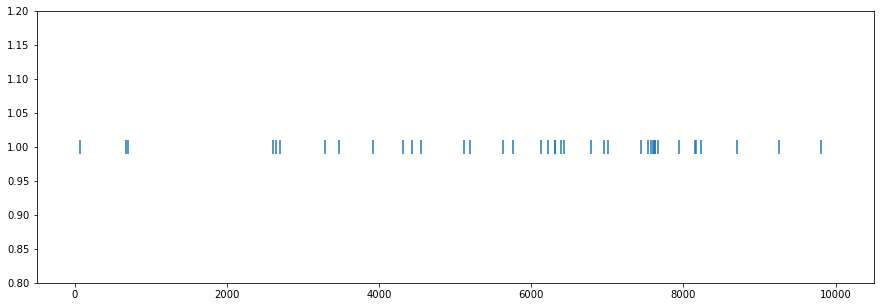

In [8]:
plt.figure(figsize = (15,5))
plt.scatter(torch.arange(10000), Z_test_pred[15000:25000].cpu().detach().numpy(), s=200, marker="|")
plt.ylim(0.8,1.2)

(0.8, 1.2)

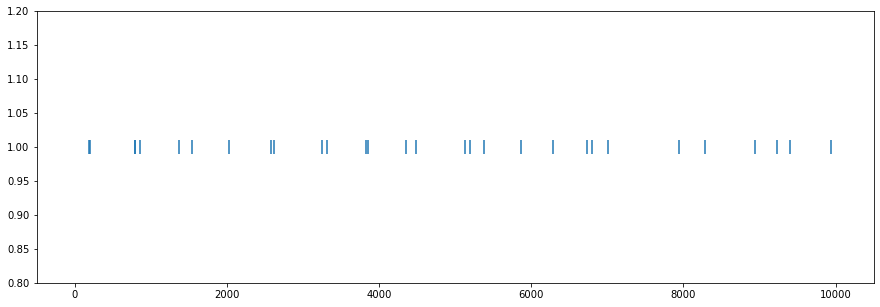

In [9]:
plt.figure(figsize = (15,5))
plt.scatter(torch.arange(10000), Z_test[15000:25000].cpu().detach().numpy(), s=200, marker="|")
plt.ylim(0.8,1.2)

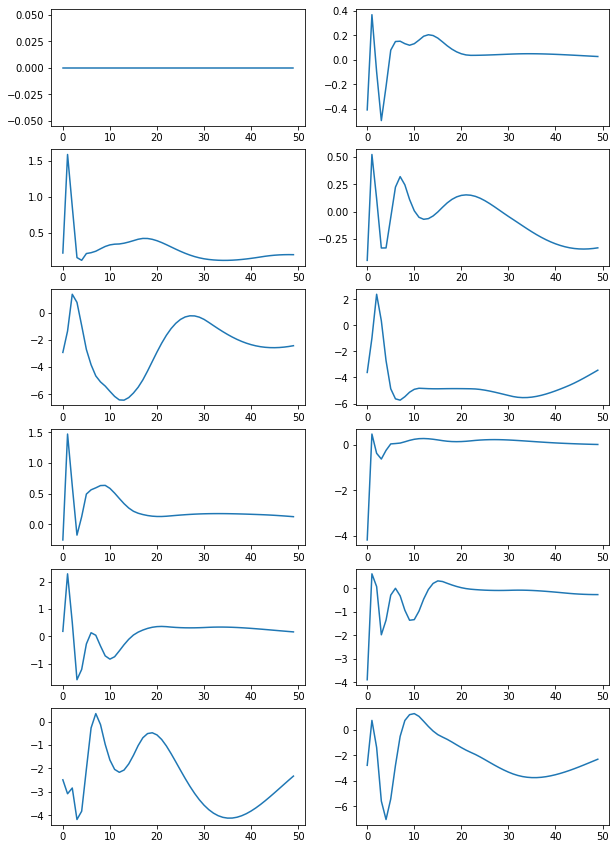

In [10]:
sub_no = 6
fig, axs = plt.subplots(nrows=sub_no,ncols=2, figsize=(10,15))
for i in range(sub_no):
    axs[i,0].plot(out_filters[i].cpu().detach().numpy())
    axs[i,1].plot(out_filters[i+sub_no].cpu().detach().numpy())
    


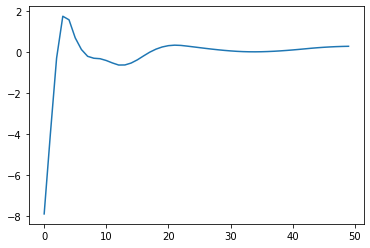

In [11]:
plt.plot(out_filters[-1].cpu().detach().numpy())